In [1]:
import re
import random
import pandas as pd
import hashlib

In [2]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

# if cards_to_age['age'].mean() > 80: age_factor = .5
# else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate', 'Jane Eyre, Bronte']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [3]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Pandas,104.202191,10.420219,18.669356,10
"Jane Eyre, Bronte",227.149923,32.449989,83.467131,7
Microsoft Purview,237.231618,4.744632,13.569384,50
DAX,284.416041,31.601782,108.098230,9
Logging in Python,490.682992,54.520332,192.434675,9
Azure AD Authentication,874.279998,72.856667,141.963830,12
TSQL,927.800858,38.658369,131.888175,24
Azure VM + Developer,1112.126654,32.709607,112.075905,34
Terraform,1355.520028,75.306668,366.131528,18
Azure Private DNS,1381.848514,72.728869,406.135659,19


# Histogram

sum of ages: ~44252.72


<Axes: >

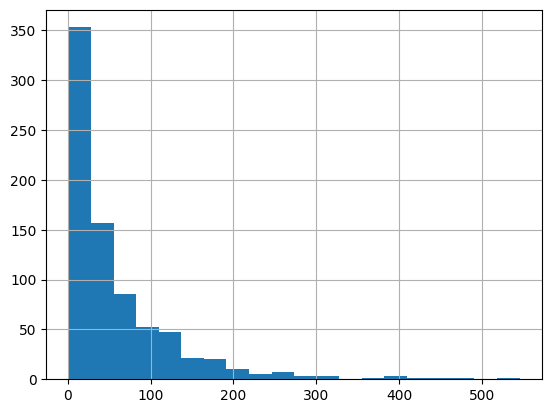

In [4]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~44252.72


<Axes: >

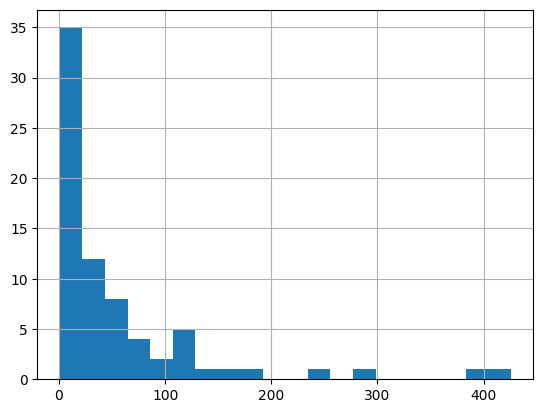

In [5]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Azure Developer Associate']['age'].hist(bins=20)

# Completely Random Shuffle

In [6]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [7]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [8]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

## Headers with greatest age sum first

In [9]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)
# existing_cards.head(10)

## Header with oldest cards first

In [10]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [11]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [12]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [13]:
n=3
m=existing_cards.shape[0]//100
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 772
Total card age: 44252.72


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
51,Azure Developer Associate,Which APIM configuration limits API calls per ...,f3ffbb13a887e8ec77e6ee870d9af2c7,-425.549718,54.484379,425.549718,-3977.359681,0.661042,0,0
52,Azure Developer Associate,Which two services guarantee FIFO delivery and...,f714061361660e025cdfbfce4b0719f2,-238.528888,54.484379,425.549718,-3977.359681,0.661042,3,0
53,Azure Developer Associate,"In Azure App Configuration,\nFilter: A filter ...",cf6c80720f3463b4f52447852937d82a,-135.427439,54.484379,425.549718,-3977.359681,0.661042,6,0
573,Azure Developer Associate,What three steps secure and document partner A...,03f5c9f6e718395acceb4aa53e17b0c9,-122.173859,54.484379,425.549718,-3977.359681,0.661042,9,0
55,Azure Developer Associate,You are developing an Azure Functions app that...,5e83b9749bf8b06e631df653a83ba32a,-88.870809,54.484379,425.549718,-3977.359681,0.661042,12,0
56,Azure Developer Associate,The top-level resource in Azure Container Inst...,3f04022b2316ce5e2c67d6b869e6aea9,-79.296924,54.484379,425.549718,-3977.359681,0.661042,15,0
57,Azure Developer Associate,You need to implement an Azure Storage lifecyc...,bf1b728607b958c3e992b65a2597c2b2,-62.333976,54.484379,425.549718,-3977.359681,0.661042,18,0
577,Azure Developer Associate,You manage an instance of Azure API Management...,c0b82fc28cca28291374fe4dd5aa53b2,-55.897789,54.484379,425.549718,-3977.359681,0.661042,21,0
59,Azure Developer Associate,You can specify external volumes to mount with...,6c6791d68279c356e8d09ea0ab3b7d9c,-49.238970,54.484379,425.549718,-3977.359681,0.661042,24,0
60,Azure Developer Associate,You manage the deployment of an Azure Cosmos D...,dba9cd44900ac2e0b6a5647f876a8f3f,-41.373830,54.484379,425.549718,-3977.359681,0.661042,27,0


## Age Mean

In [14]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [15]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [16]:
# n=5
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [17]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [18]:
if existing_cards.age.sum() < 0:
    asc = True
else: asc = False
existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
0,PowerShell Modules,Install-Module\n\nDefinition: A cmdlet used to...,abd837efe7378e3e46b08d09a459cae3,-545.676551,88.857386,545.676551,-2843.436368,0.210953,0,0
11,Azure Compute Gallery,VM Deployment from ACG – The process of creati...,9b589f2fb52eedf61e2dc11f57da0d0f,-465.125215,79.558348,465.125215,-3182.333905,0.315071,0,0
25,Azure Functions + PP365,API Gateway Integration\nConnecting Azure Func...,d0210993b8fa777c35753f8d26d9c4a9,-454.088889,84.967697,454.088889,-1784.321632,0.675915,0,0
51,Azure Developer Associate,Which APIM configuration limits API calls per ...,f3ffbb13a887e8ec77e6ee870d9af2c7,-425.549718,54.484379,425.549718,-3977.359681,0.661042,0,0
32,Azure Private DNS,DNS Proxy\nDefinition: A feature that allows D...,7afb51ca2c17c5d23a40fbb536b4ef56,-406.135659,72.728869,406.135659,-1381.848514,0.404861,0,0
39,FSLogix,Q: How does FSLogix Profile Container enhance ...,6e14a79eafeac794c566a2f5be07a49e,-400.972815,80.888530,400.972815,-2750.210004,0.427468,0,0
315,Azure Developer Associate,You have an Azure event hub. You need to add p...,e1d05b7e22576ea7494bc54377cf9d46,-399.331996,54.484379,425.549718,-3977.359681,0.661042,1,1
76,Terraform,terraform validate:\nA CLI command that checks...,036e232f01695e400da5847ea8babd0d,-366.131528,75.306668,366.131528,-1355.520028,0.194048,0,0
82,Python,Q:\nHow can you obtain command-line arguments ...,6a00d6335b8d45302a333e507237865b,-318.735589,47.881470,318.735589,-2872.888222,0.244550,0,0
116,C# Basics,What’s the difference between delegates and ev...,aafda82832da4aaff149c8153e06fc0a,-314.089572,63.790983,314.089572,-1977.520475,0.403571,0,0


In [19]:
existing_cards['age'].mean()

-57.32217308715063